<a href="https://colab.research.google.com/github/HamzaGbada/Local-Ocean-Conservation-Sea-Turtle-Face-Detection/blob/main/Local_Ocean_Conservation_Sea_Turtle_Face_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

The Local Ocean Conservation - Sea Turtle Face Detection on Zindi challenges participants to build an algorithm capable of drawing a bounding box around the all-important facial scales of a sea turtle. 

In this notebook we'll look at the data and build a very basic solution.

# Loading the data

In [ ]:
from PIL import Image, ImageDraw
import pandas as pd
from matplotlib import pyplot as plt

In [ ]:
# You can choose the 1024px version instead, but these are nice for initial testing
!cp 'IMAGES_512.zip' .
!unzip -q IMAGES_512.zip
image_folder = 'IMAGES_512'

In [ ]:
# Load train - edit path to suit your setup
train = pd.read_csv('Train.csv')
print(train.shape)
train.head()

(1326, 5)


,Image_ID,x,y,w,h
0,04FB1B33,0.481988,0.506076,0.174696,0.405671
1,B04E481E,0.617405,0.313368,0.177734,0.293113
2,32655645,0.490885,0.465856,0.165582,0.357350
3,44D4DA7C,0.472873,0.506076,0.237847,0.409722
4,4F36EF72,0.433811,0.574363,0.180773,0.397569


# View an Image

Let's check that we have the images where we expect them, and plot a bounding box to visualize our goal here:

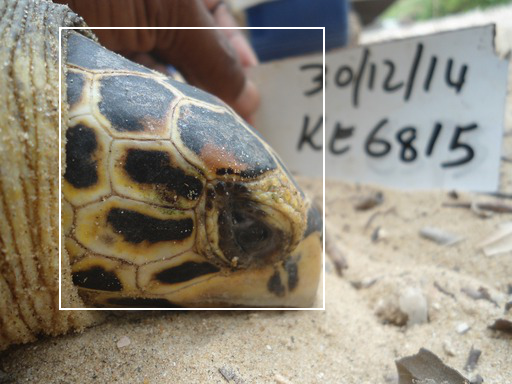

In [ ]:
# Take a sample row
imid, x, y, w, h = train.sample().values[0]

# Open with PIL and draw a bounding box
with Image.open(f'{image_folder}/{imid}.JPG') as im:
  imw, imh = im.size # Box coords are relative to image size
  draw = ImageDraw.Draw(im)
  draw.rectangle([int(x*imw), int(y*imh), int((x+w)*imw), int((y+h)*imh)], width=2)
im

# Object Detection

There are many ways to do object detection. Unfortunately, most require quite a bit of code and explanation. Rather than getting bogged down in a complex approach, I'm going to take a somewhat sub-optimal approach for illustrative purposes. The point here is to get a very basic model, so that we can look at evaluation and submissions. 

The approach I'll be taking is to frame this as an image regression problem, with the bounding box x, y, w and h as four independant regression outputs.

In [ ]:
!pip install --upgrade -q fastcore fastai # Get latest library versions

     |████████████████████████████████| 61kB 7.5MB/s 
     |████████████████████████████████| 194kB 27.1MB/s 
     |████████████████████████████████| 12.8MB 254kB/s 
     |████████████████████████████████| 776.8MB 23kB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.


In [ ]:
from fastai.vision.all import *

### Preparing the data

I'm using and abusing the DataBlock API here. It looks a little scary but we specify the input and output blocks, tell it how to get the data, add a validation split, specify transforms and turn the whole lot into some dataloaders :)

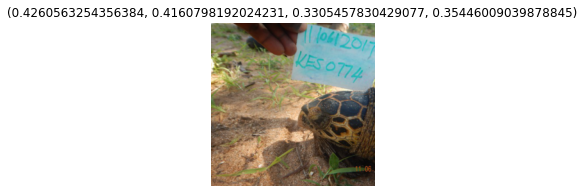

In [ ]:
dblock = DataBlock(
  blocks=(ImageBlock(), RegressionBlock(n_out=4)),      # one image input and four numeric outputs
  getters=[ColReader('Image_ID', pref=f'{image_folder}/', suff='.JPG'),   # image input
           ColReader(['x', 'y', 'w', 'h'])],                              # The four outputs
  splitter=RandomSplitter(),                                              # train/validation split
  item_tfms = [Resize(256)],                                  # Make sure all inputs are the same size
  batch_tfms=None,                                            # No transforms for this
  n_inp = 1                                                   # Specify number of inputs
) 
dls = dblock.dataloaders(train, bs=64)   # Create the dataloaders
dls.show_batch(max_n=1) # View one item - note the four outputs

### Create and train the leaner

In [ ]:
import torchvision.models as models
import torch
torch.cuda.empty_cache()
import gc
gc.collect()

# We specify n_out and y_range, and pick a loss function.
learn = cnn_learner(dls, vgg19_bn, n_out=4, y_range=(0, 1), 
                    loss_func=MSELossFlat(reduction='mean'))

In [ ]:
# Minimal Training
learn.fine_tune(1)

epoch,train_loss,valid_loss,time
0,0.116792,0.067108,00:22


epoch,train_loss,valid_loss,time
0,0.100987,0.043243,00:30


### A custom metric (Optional)

Interpreting MSE isn't easy - let's use the same metric as Zindi, Intersection Over Union. 

In [ ]:
# The 
def iou(boxA, boxB):
  # boxA is actually the predictions - a list of [[x, y, w, h], ...]
  # boxB is the targets, same format

  # determine the (x, y)-coordinates of the intersection rectangle
  xA = torch.max(boxA[:,0], boxB[:,0]) # box[:,0] => x
  yA = torch.max(boxA[:,1], boxB[:,1]) # box[:,1] => y
  xB = torch.min(boxA[:,0] + boxA[:,2], boxB[:,0] + boxB[:,2]) # box[:,0] + box[:,2] => x+w 
  yB = torch.min(boxA[:,1] + boxA[:,3], boxB[:,1] + boxB[:,3]) # y+h
  
  eps = 1e-5 # To avoid division by 0

  # area of intersection
  interArea = torch.clamp((xB - xA + eps), 0, 1) * torch.clamp((yB - yA + eps), 0, 1)

  # compute the area of both rectangles
  
  boxAArea = (boxA[:,2] + eps) * (boxA[:,3] + eps) # w*h
  boxBArea = (boxB[:,2] + eps) * (boxB[:,3] + eps) # w*h
    
  # IOU
  iou = interArea / (boxAArea + boxBArea - interArea)
    
  return iou.mean() # Average IOU over all items in batch

In [ ]:
import torchvision.models as models
import torch
torch.cuda.empty_cache()
import gc
gc.collect()

learn = cnn_learner(dls, alexnet, n_out=4, y_range=(0, 1), 
                    loss_func=MSELossFlat(reduction='mean'),
                    metrics=iou)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


In [ ]:
learn.fine_tune(3)

epoch,train_loss,valid_loss,iou,time
0,0.119169,0.071493,0.099590,00:07


epoch,train_loss,valid_loss,iou,time
0,0.099684,0.052653,0.136227,00:07
1,0.093665,0.040804,0.155580,00:07
2,0.088328,0.038494,0.160910,00:07


### View some examples of the model predictions

Here we pull a random image from the training set and overlay the prediction with the actual bounding box.

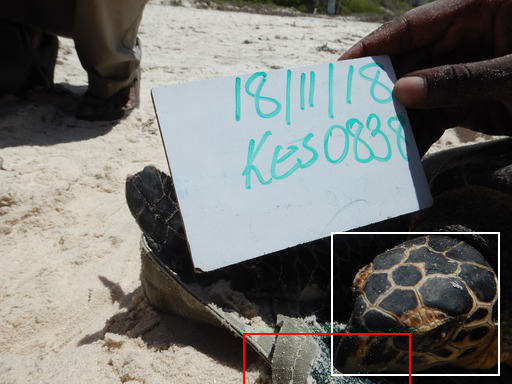

In [ ]:
# Take a sample row
imid, x, y, w, h = train.sample().values[0]

# Get preds
xp, yp, wp, hp = learn.predict(f'{image_folder}/{imid}.JPG')[0]

# View
with Image.open(f'{image_folder}/{imid}.JPG') as im:
  imw, imh = im.size # Box coords are relative to image size
  draw = ImageDraw.Draw(im)
  draw.rectangle([int(x*imw), int(y*imh), int((x+w)*imw), int((y+h)*imh)], width=2) # Actual
  draw.rectangle([int(xp*imw), int(yp*imh), int((xp+w)*imw), int((yp+h)*imh)], width=2, outline='red') # Pred
im

# Saving Predictions

In [ ]:
# Load sample submission
ss = pd.read_csv('SampleSubmission.csv')
ss.head(2)

,Image_ID,x,y,w,h
0,4863D911,0,0,0,0
1,6DD3ADD5,0,0,0,0


In [ ]:
# This step may be more complex depending on your model and library choices, but
# here getting predictions on the test set is as simple as:
tdl = dls.test_dl(ss)
preds =learn.get_preds(dl=tdl)

In [ ]:
# Updating the columns with the predictions
ss.loc[:,['x', 'y', 'w', 'h']] = preds[0].numpy()
ss.head()

,Image_ID,x,y,w,h
0,4863D911,0.523332,0.336817,0.507032,0.519489
1,6DD3ADD5,0.503211,0.311259,0.200665,0.641066
2,E8DC4D6A,0.304257,0.783060,0.340986,0.274026
3,E02ABB6C,0.572806,0.300068,0.648898,0.660856
4,875C19F4,0.541369,0.614464,0.520638,0.437028


In [ ]:
# Save for submission
ss.to_csv('Submission1.csv', index=False)

In [ ]:
# Score: ~0.12 on public LB

# Where Next?

This submission scores ~0.12, not too far from the ~0.15 we saw during training (the test set contains different individuals to the training set, hence the slightly lower score). Looking through some examples, it's not terrible, but there is a **lot** of room for improvement.

As mentioned, this notebook is mainly to show the task and provide a minimal example with submission format and so on. The actual model has many potential improvements, including:

- Changing to an output format that get's transformed when the inputs are transformed - this might mean converting to fastai's PointBlock or BBoxBlock format, or writing a custom datablock
- Properly accounting for image dimensions and how they relate to the label format
- Using a more established object-detection approach such as YOLOv3
- A loss function more optimized for this kind of task.
- Better training, larger model, ensembles etc. Although please bear in mind the end goal of this challenge: something that can be used by LOC to process images from the field. A single well-designed model would be VERY much appreciated :)

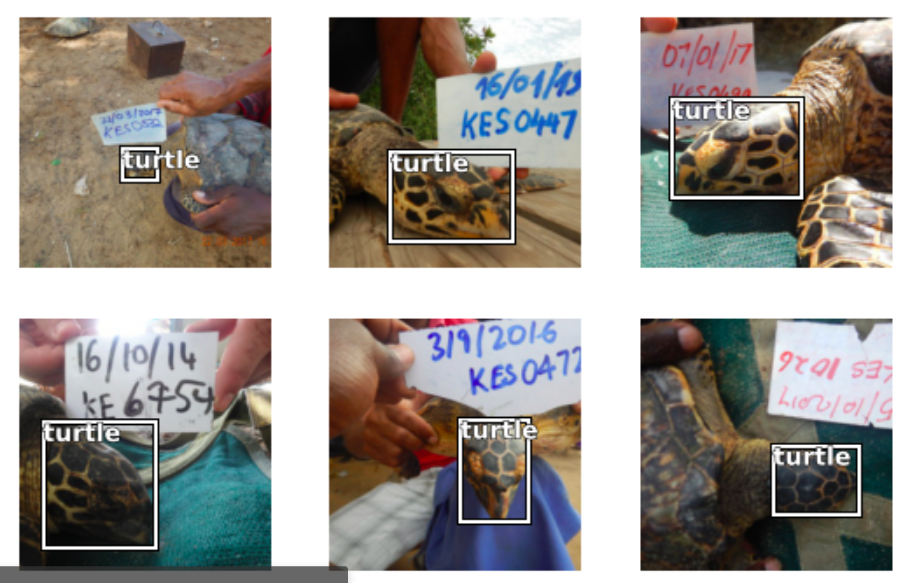

The above image shows this task framed as a more traditional labelled bounding-box style task. If you've found a beginner-frinedly way to work with this kind of data, please share on the discussion forums! All the examples I could find needed a crazy amount of copy-pasting code to get working. 